<a href="https://colab.research.google.com/github/CzSadykov/car_price_predictions/blob/main/Used_car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Used car price prediction

**Problem Situation:** A supposed car dealership is developing an app to attract new customers. In it, you can quickly find out the market value of your car.

**Task:** to build a model to determine the cost, the RMSE metric should be **less than 2500 euros**.

**Criteria for evaluating work by the customer:**

- quality of prediction;
- prediction speed;
- studying time.

**Data:** historical. That is, the technical characteristics, equipment and prices of cars.

**Variables used:**

* ``DateCrawled`` — date of downloading the questionnaire from the database;
* ``VehicleType`` — car body type;
* ``RegistrationYear`` — year of vehicle registration;
* ``Gearbox`` — gear box type;
* ``Power`` - power (hp);
* ``Model`` — car model;
* ``Kilometer`` — mileage (km);
* ``RegistrationMonth`` — car registration month;
* ``FuelType`` — fuel type;
* ``Brand`` — car brand;
* ``Repaired`` - was the car under repair or not;
* ``DateCreated`` — date of creation of the questionnaire;
* ``NumberOfPictures`` - number of car photos;
* ``PostalCode`` — postal code of the owner of the profile (user);
* ``LastSeen`` is the date of the user's last activity.

**Target attribute:**

* ``Price`` - price in euro.

**Plan**:

So, let's start by importing the libraries and the models we use. In this problem, we will test predictions based on:

1) Linear regression;

2) Light GBM;

3) CatBoost.

In [55]:
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Data preprocessing

### Exploring the data

In [3]:
def df_read(file_path):
    df = pd.read_csv(file_path)
    display(df.head())
    print(df.info(), '\n')
    print('Duplicates:', '\n', sum(df.duplicated()), '\n')
    print('Missing values:', '\n', df.isna().sum(), '\n')
    return df

In [4]:
df = df_read('https://code.s3.yandex.net/datasets/autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

We see a lot of missing values, a few duplicates and inappropriate variable types. Let's put it all in order, starting with the type of variables that represent dates.

In [5]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

Now we remove duplicates and look at the top-level descriptions for each variable.

In [6]:
df = df.drop_duplicates().reset_index(drop=True)
df.describe(include='all', datetime_is_numeric=True)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,354365.000000,321470,354365,283211,354365,354365.0,354365.000000,354365
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,NaN,NaN,NaN,NaN
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,NaN,NaN,NaN,NaN
freq,7,NaN,91457,NaN,268249,NaN,29232,NaN,NaN,216349,77012,247158,NaN,NaN,NaN,NaN
mean,NaN,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,2016-03-20 19:12:06.583042560,0.0,50508.503800,2016-03-29 23:51:06.766184960
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:52
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,NaN,20000.000000,NaN,9999.000000,NaN,20000.000000,NaN,150000.000000,12.000000,NaN,NaN,NaN,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51


We see that the ``NumberOfPictures`` variable contains only zeros - we definitely won't need it. Also, when solving the problem, we definitely won’t need the nominal variable ``PostalCode`` (postal code) and the variable ``DateCrawled``, which practically duplicates the ``DateCreated`` variable, only adding unnecessary precision to it.

Let's delete them.

In [7]:
df = df.drop(columns=['DateCrawled', 'NumberOfPictures', 'PostalCode'])

Now let's take a look at the passes. We certainly cannot fill in the gaps in the ``Model`` and ``Repaired`` variables. In the first case, we will throw out these passes, since there are relatively few of them (19,705).

But in the case of the ``Repaired`` variable, there are more than 71,000 of them. Therefore, we will replace the unknown values with the value **unknown**.

In [8]:
df = df.dropna(subset=['Model'])

In [ ]:
df['Repaired'] = df['Repaired'].fillna('unknown')

Let's look at the omissions now.

In [10]:
df.isna().sum()

Price                    0
VehicleType          30662
RegistrationYear         0
Gearbox              15702
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             25732
Brand                    0
Repaired                 0
DateCreated              0
LastSeen                 0
dtype: int64

Missed values remain in three nominal variables, reflecting the vehicle type, its gearbox and the fuel used.

We can fill in these gaps by grouping the data by car model and filling it in based on the most common values for those models - after all, the same models probably have the same vehicle types, gearboxes and fuels.

But first, let's look at what kind of numerical data we are dealing with, on histograms.

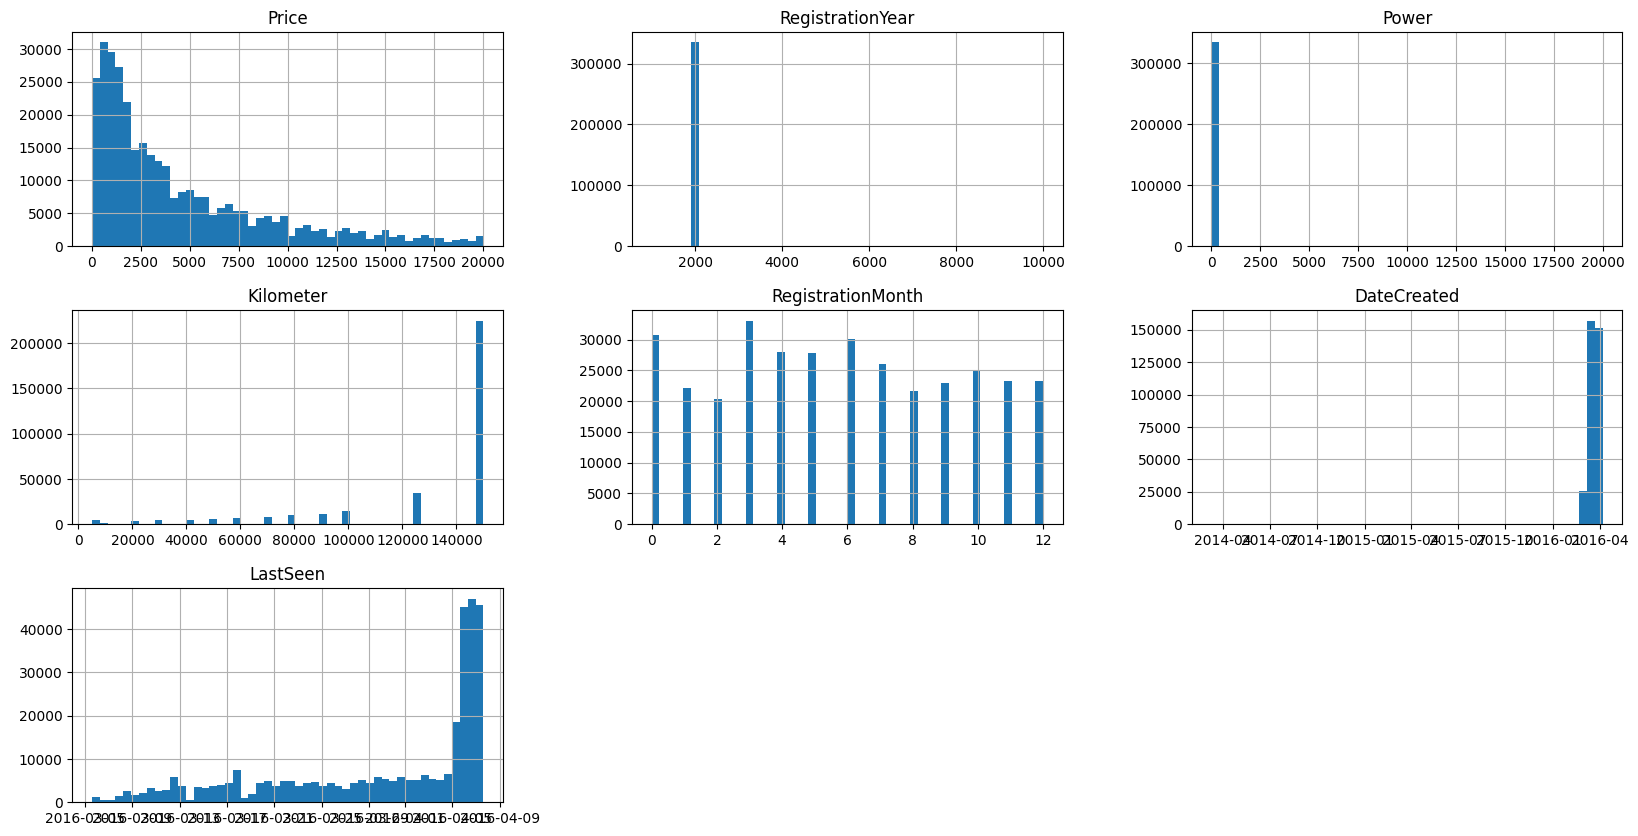

In [13]:
df.hist(bins=50, figsize=(20,10));

With variables that are related to dates in one way or another, everything is clear, with the exception of the ``RegistrationYear`` variable - in the table above, we saw obvious outliers in its minimum and maximum values. The distributions of the ``Price``, ``Power``, and ``Kilometer`` variables we need will also be examined in more detail.

Let's start with the year of registration.

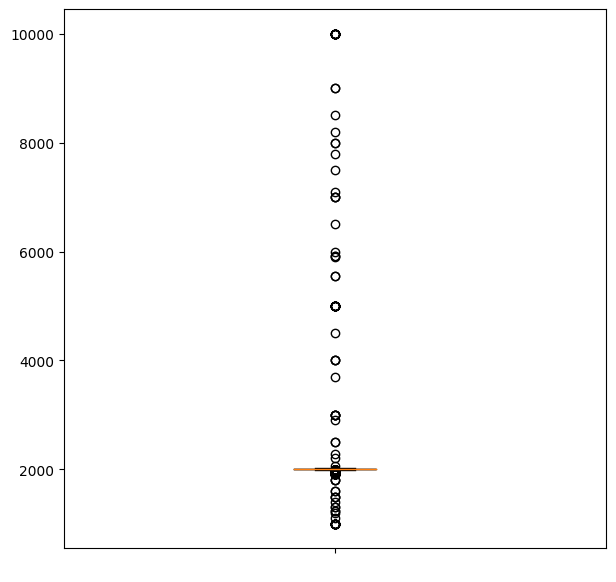

In [14]:
plt.figure(figsize=(7,7))

plt.boxplot(df['RegistrationYear'], labels=' ');

We see a large number of outliers - especially unrealistic registration year values after 2016 (the maximum year in the ``DateCreated`` variable, for example). Let's leave for ourselves only the range from 1900 (maybe the antique cars are also presented on the platform...) to 2016. First, let's replace the outliers with NaNs.

In [15]:
df.loc[((df['RegistrationYear'] > 2016) | (df['RegistrationYear'] < 1900)), 'RegistrationYear'] = np.NaN

Let's calculate how many missed values we have now.

In [16]:
df['RegistrationYear'].isna().sum()

12516

Let's fill in these missed values based on the most frequent registration year values for certain car models.

In [17]:
df['RegistrationYear'] = df['RegistrationYear'].fillna(df.groupby('Model')['RegistrationYear']\
                                             .transform(lambda x: x.value_counts().idxmax()))

Let's see what the distribution of the variable looks like now.

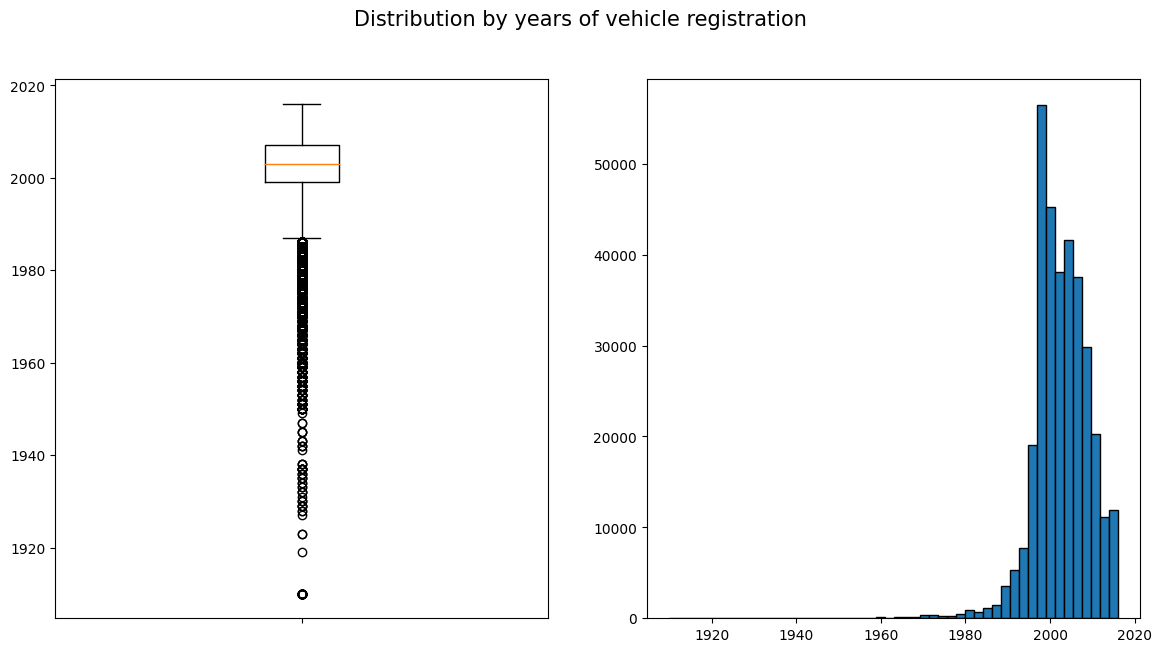

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,7));

fig.suptitle('Distribution by years of vehicle registration', fontsize=15)

ax[0].boxplot(df['RegistrationYear'], labels=' ');

ax[1].hist(df['RegistrationYear'], bins=50, edgecolor='black');

Much better! We can work with that.  

Now let's take a look at the box plots of our target trait and its (rather important) potential predictors.

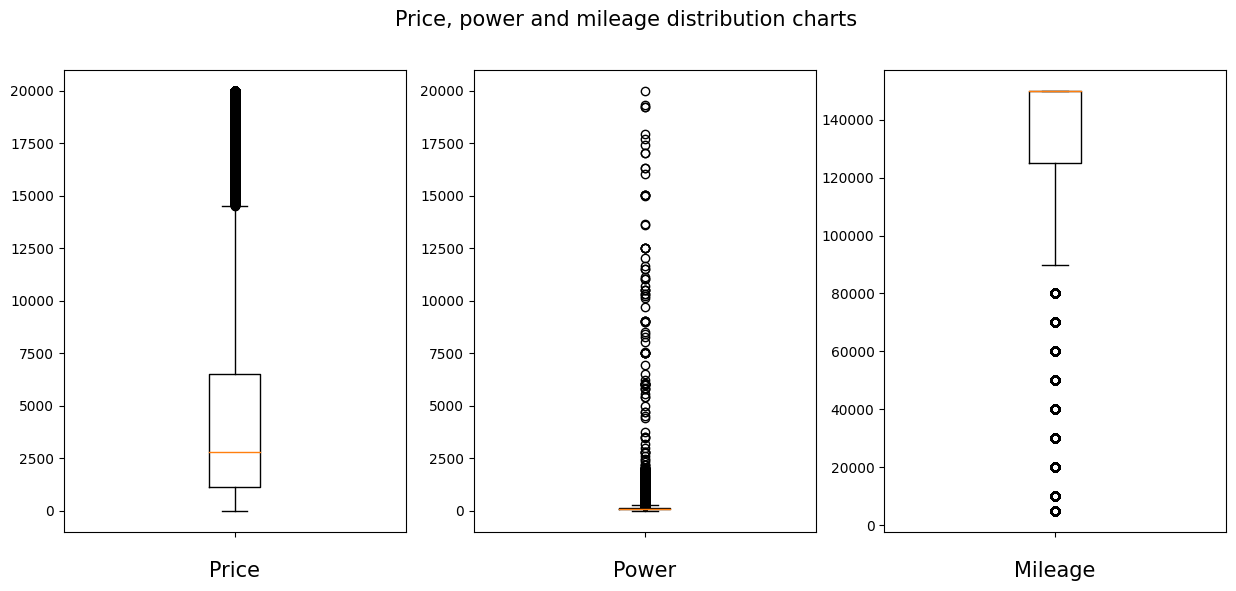

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15,6));

fig.suptitle('Price, power and mileage distribution charts', fontsize=15)

ax[0].boxplot(df['Price'], labels=' ');
ax[0].set_xlabel('Price', fontsize=15);

ax[1].boxplot(df['Power'], labels=' ');
ax[1].set_xlabel('Power', fontsize=15);

ax[2].boxplot(df['Kilometer'], labels=' ');
ax[2].set_xlabel('Mileage', fontsize=15);


We definitely need to remove the zero value of the price. But outliers within reasonable limits are generally acceptable here.

The same cannot be said about power - anything above 1000 horsepower is completely unrealistic. We will also replace them with NaNs.

We see a strange cutoff along the median for the mileage variable. This is probably the maximum allowable mileage that can be set on the site, so there is a significant bias in its direction. There are also outliers approaching zero. Among them, we can substitute too low (<15 km) values with NaNs.

In [20]:
df.loc[(df['Price'] == 0), 'Price'] = np.NaN
df.loc[((df['Power'] == 0) | (df['Power'] > 1000)), 'Power'] = np.NaN
df.loc[(df['Kilometer'] < 15), 'Kilometer'] = np.NaN

Let's see how many NaNs we have now.

In [21]:
print(df['Price'].isna().sum())
print(df['Power'].isna().sum())
print(df['Kilometer'].isna().sum())

8588
34196
0


Quite a lot in the price variable, even more in the power variable, and zero in the mileage variable. Well, then we will continue to work with the first two.

Let's fill in the NaNs based on the median values of price and power for certain car models.

In [22]:
df['Price'] = df['Price'].fillna(df.groupby('Model')['Price'].transform('median'))
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))

In [23]:
print(df['Price'].isna().sum())
print(df['Power'].isna().sum())

0
2


For some reason, two gaps in the variable power were not filled. Let's look at them.

In [24]:
df.loc[df['Power'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,LastSeen
234294,3800.0,wagon,1978.0,manual,NaN,serie_1,30000.0,0,gasoline,land_rover,unknown,2016-03-30,2016-03-30 11:39:08
280213,3800.0,NaN,1970.0,NaN,NaN,serie_1,100000.0,0,petrol,land_rover,unknown,2016-04-02,2016-04-06 09:16:22


Let's try to remove it again.

In [25]:
df['Power'] = df['Power'].dropna()

In [26]:
print(df['Power'].isna().sum())

2


Wow! Quite stubborn they are. But we will defeat them with the help of index filtering.

In [27]:
nanlist = df.loc[df['Power'].isna()].index.tolist()

In [28]:
df = df.drop(nanlist, axis=0)

In [29]:
print(df['Power'].isna().sum())

0


It worked! Now let's take a look at the diagrams after processing the anomalies.

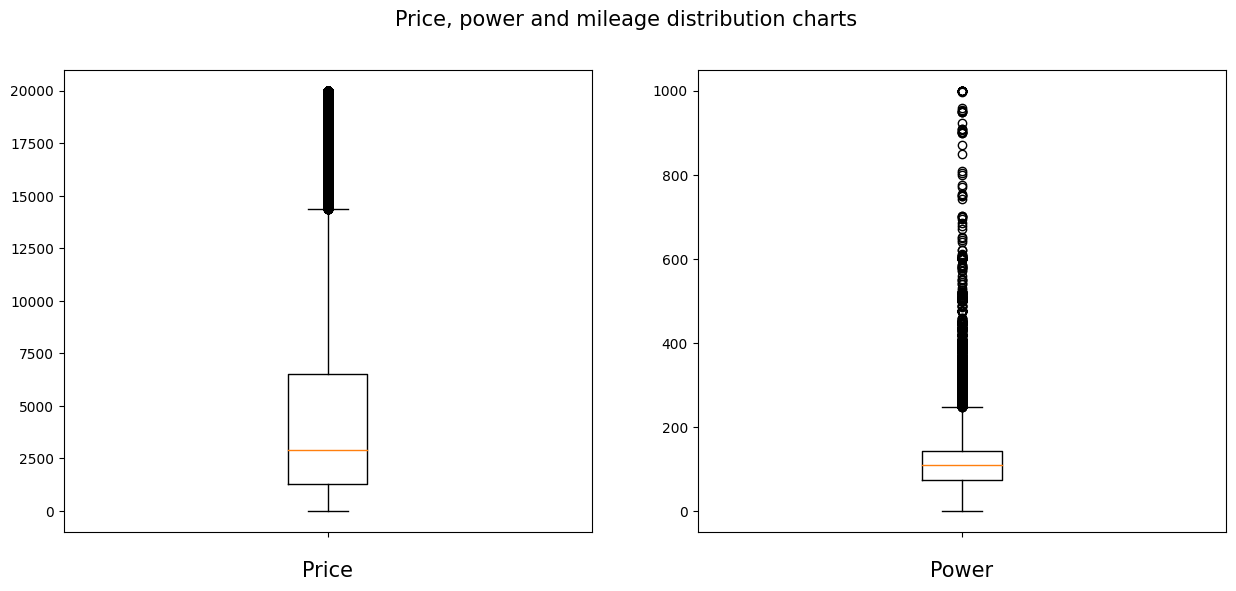

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15,6));

fig.suptitle('Price, power and mileage distribution charts', fontsize=15)

ax[0].boxplot(df['Price'], labels=' ');
ax[0].set_xlabel('Price', fontsize=15);

ax[1].boxplot(df['Power'], labels=' ');
ax[1].set_xlabel('Power', fontsize=15);

It looks like something realistic. That's what we'll be working with.

Now, as mentioned earlier, we will replace the NaNs in the nominal variables on the basis of the most frequent values.

In [31]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby('Model')['VehicleType']\
                                             .transform(lambda x: x.value_counts().idxmax()))
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['Gearbox']\
                                     .transform(lambda x: x.value_counts().idxmax()))
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType']\
                                       .transform(lambda x: x.value_counts().idxmax()))

Now let's process our remaining date variables ``DateCreated`` and ``LastSeen`` so they can be used in the model.

We'll  take the base date (the minimum value of the ``DateCreated`` variable) and count the number of days since.

In [32]:
min(df['DateCreated'])

Timestamp('2014-03-10 00:00:00')

In [33]:
base_date = pd.Timestamp('2014-03-10 00:00:00')
df['DateCreated'] = df['DateCreated'].transform(lambda x: (pd.Timestamp(x) - base_date).days)
df['LastSeen'] = df['LastSeen'].transform(lambda x: (pd.Timestamp(x) - base_date).days)

Now, in order to reduce the dimensionality, let's combine the ``Brand`` and ``Model`` variables into one, since this will not distort the data in any way, but it will help us simplify the encoding.

In [34]:
df['brand_model'] = df['Brand'] + ' ' + df['Model']
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,LastSeen,brand_model
0,480.0,sedan,1993.0,manual,101.0,golf,150000.0,0,petrol,volkswagen,unknown,745,759,volkswagen golf
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8,gasoline,jeep,unknown,735,757,jeep grand
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,6,petrol,volkswagen,no,738,738,volkswagen golf
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7,gasoline,skoda,no,752,758,skoda fabia
5,650.0,sedan,1995.0,manual,102.0,3er,150000.0,10,petrol,bmw,yes,756,758,bmw 3er


In [35]:
df = df.drop(columns=['Brand', 'Model'])

And finally, after we have processed all the columns and removed the excess, we will make the names in the snake case :)

In [37]:
df.columns = df.columns.str.lower()
df.head()

,price,vehicletype,registrationyear,gearbox,power,kilometer,registrationmonth,fueltype,repaired,datecreated,lastseen,brand_model
0,480.0,sedan,1993.0,manual,101.0,150000.0,0,petrol,unknown,745,759,volkswagen golf
2,9800.0,suv,2004.0,auto,163.0,125000.0,8,gasoline,unknown,735,757,jeep grand
3,1500.0,small,2001.0,manual,75.0,150000.0,6,petrol,no,738,738,volkswagen golf
4,3600.0,small,2008.0,manual,69.0,90000.0,7,gasoline,no,752,758,skoda fabia
5,650.0,sedan,1995.0,manual,102.0,150000.0,10,petrol,yes,756,758,bmw 3er


In [38]:
df = df.rename(columns = {'vehicletype' : 'vehicle_type',
               'registrationyear' : 'registration_year',
               'registrationmonth' : 'registration_month',
               'fueltype' : 'fuel_type',
               'datecreated' : 'date_created',
               'lastseen' : 'last_seen'})

In [39]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,repaired,date_created,last_seen,brand_model
0,480.0,sedan,1993.0,manual,101.0,150000.0,0,petrol,unknown,745,759,volkswagen golf
2,9800.0,suv,2004.0,auto,163.0,125000.0,8,gasoline,unknown,735,757,jeep grand
3,1500.0,small,2001.0,manual,75.0,150000.0,6,petrol,no,738,738,volkswagen golf
4,3600.0,small,2008.0,manual,69.0,90000.0,7,gasoline,no,752,758,skoda fabia
5,650.0,sedan,1995.0,manual,102.0,150000.0,10,petrol,yes,756,758,bmw 3er


### Data encoding, sampling, and scaling

Let's extract the target feature, split the data into training and test samples. Then, before training the models, we need to transform the nominal variables using the One-Hot Encoding, and after that, scale the numeric variables using the StandardScaler.

In [40]:
target = df['price']
features = df.drop(columns='price')

Now let's split the data in a 3:1 ratio, where 3/4 is the training sample, and 1/4 is the test sample.

In [41]:
RANDOM_STATE = 11235

In [42]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                           target,
                                                                           test_size=0.25,
                                                                           random_state=RANDOM_STATE)

In [43]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(250993, 11)
(83665, 11)
(250993,)
(83665,)


Now it's OHE time.

In [44]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

We make sure that the samples have the same features.

In [45]:
common_columns = set(features_train.columns)\
& set(features_test.columns)

features_train = features_train[list(common_columns)]
features_test = features_test[list(common_columns)]

In [ ]:
print(len(features_train.columns) == len(features_test.columns))

True


Great, we can move on to scaling.

In [46]:
pd.options.mode.chained_assignment = None

numeric = ['registration_year',
          'power',
          'kilometer',
          'registration_month',
          'date_created',
          'last_seen']

In [47]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] =  scaler.transform(features_test[numeric])

The features are scaled, let's start training the models.

## Training the models

We start training models with a dummy model that makes predictions based on the mean. This will make it easier for us to compare results.

In [48]:
%%time

dummy_predictions = pd.Series(target_train.mean(), index=target_test.index)
dummy_rmse = mean_squared_error(target_test, dummy_predictions, squared = False)
print(f'RMSE of dummy model based on mean is: {dummy_rmse:.3f}')

RMSE of dummy model based on mean is: 4492.810
CPU times: user 6.76 ms, sys: 0 ns, total: 6.76 ms
Wall time: 11.9 ms


Got that. Now let's look at linear regression.

### Linear regression

We will get the RMSE of linear regression during cross-validation on 5 blocks. At the same time, we measure the training time.

In [49]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

lr_rmse = cross_val_score(lr_model,
                          features_train,
                          target_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')
print(f'RMSE for Linear regression: {-lr_rmse.mean():.3f}')

RMSE for Linear regression: 2643.462
CPU times: user 1min 47s, sys: 20 s, total: 2min 7s
Wall time: 1min 45s


We improved RMSE by almost 2 times! At the same time, cross-validation on 5 blocks took 1 minute and 45 seconds.

Let's check how long pure predictions take.

In [51]:
%%time

lr_predictions = lr_model.predict(features_train)

CPU times: user 286 ms, sys: 226 ms, total: 513 ms
Wall time: 446 ms


Now let's check LightGBM.

### LightGBM

Let's extract categorical features for LightGBM.

In [52]:
categorical_train = [col for col in features_train if col not in numeric]

Now let's prepare the datasets used by the model.

In [ ]:
%%time

lgb_train = lgb.Dataset(features_train, target_train, categorical_feature = categorical_train)
lgb_test = lgb.Dataset(features_test)

CPU times: user 18 µs, sys: 10 µs, total: 28 µs
Wall time: 31 µs


We use cross-validation using the RandomizedSearch method on 5 blocks with enumeration of the learning rate (from 0.1 to 0.5 with a step of 0.1) and the maximum depth of the tree (from 1 to 11 with a step of 2).

In [ ]:
%%time

parameters_grid = {'learning_rate' : (np.arange(0.1, 0.6, 0.1)),
                  'max_depth' : (np.arange(1, 12, 2))}

lgb_model = LGBMRegressor(n_jobs=2)

lgb_cv = RandomizedSearchCV(estimator=lgb_model,
                    param_distributions=parameters_grid,
                   cv=5,
                    verbose=2,
                   scoring='neg_root_mean_squared_error')

lgb_cv.fit(features_train, target_train)

It took us 4 minutes 41 seconds to train the model with cross-validation and hyperparameter fitting. Let's see which model got the best results.

In [59]:
print(f'RMSE of LightGBM: {-lgb_cv.best_score_:.3f}', '\n')
print(f'Best hyperparameters: {lgb_cv.best_params_}')

RMSE of LightGBM: 1695.991 

Best hyperparameters: {'max_depth': 11, 'learning_rate': 0.30000000000000004}


We managed to improve the RMSE by almost 1000 euros. Let's estimate the time of predictions separately.

In [60]:
%%time

lgb_predictions = lgb_cv.predict(features_train)

CPU times: user 3.07 s, sys: 1.73 s, total: 4.79 s
Wall time: 4.21 s


Slightly more than 2 secs.

But in order to compare LightGBM not only with the dummy model and simple linear regression, let's evaluate another model with gradient boosting - CatBoost.

### CatBoost

Let's use the same technique to train and analyze the applicability of the CatBoost model.

In [ ]:
%%time

cb_model = CatBoostRegressor()

cb_cv = RandomizedSearchCV(estimator=cb_model,
                    param_distributions=parameters_grid,
                   cv=5,
                    verbose=2,
                   scoring='neg_root_mean_squared_error')

cb_cv.fit(features_train, target_train, cat_features=categorical_train)

**The model has been training for 1 hour 3 minutes.**

Let's measure the time of predictions.

In [64]:
%%time

cb_cv.predict(features_train)

CPU times: user 30 s, sys: 155 ms, total: 30.1 s
Wall time: 35.1 s


array([ 6523.55203197, 10799.31996792, 19081.49957256, ...,
        1911.325471  ,  7826.89545258,  7622.58198517])

Well, let's see if the training of the model was worth it, and which hyperparameters bring the best result.

In [67]:
%%time

print(f'RMSE of CatBoost: {-cb_cv.best_score_:.3f}', '\n')
print(f'The best hyperparameters: {cb_cv.best_params_}')

RMSE of CatBoost: 1583.977 

The best hyperparameters: {'max_depth': 11, 'learning_rate': 0.2}
CPU times: user 182 µs, sys: 4 µs, total: 186 µs
Wall time: 190 µs


So, it turns out that we've spent 1 hour to get the 100-euro RMSE improvement. We'll consider that ineffective.

## Comparing the models

Let's collect all the results obtained during the training of models.

In [68]:
res_index = ['Linear regression', 'Light GBM', 'CatBoost']
res_columns = ['Training (+CV) time', 'Prediction time', 'RMSE']

results = pd.DataFrame(index=res_index, columns=res_columns)

results['Training (+CV) time'] = ['1 min, 45 sec', '4 min, 41 sec', '1 hour, 3 min']
results['Prediction time'] = ['446 ms', '4 sec', '35 sec']
results['RMSE'] = [2643, 1696, 1584]

display(results)

,Training (+CV) time,Prediction time,RMSE
Linear regression,"1 min, 45 sec",446 ms,2643
Light GBM,"4 min, 41 sec",4 sec,1696
CatBoost,"1 hour, 3 min",35 sec,1584


Our leaders based on RMSE are Light GBM and Catboost. But considering an extremely significant difference in training time (almost 1 hour) we can recommend Light GBM since our trade-off is only 112 euro.

## Performance validation on the test data

Now let's validate our Light GBM model on a test data.

In [69]:
predictions = lgb_cv.predict(features_test)

print(f'RMSE on the test data: {mean_squared_error(target_test, predictions, squared=False):.3f}', '\n')

RMSE on the test data: 1686.629 



**Our final RMSE is 1687 euro.** The model is performing even better than during training. And we've passed the threshold defined in our initial requirements (2500 euro).

A final sanity check:

In [72]:
dummy_predictions = pd.Series(
    index=target_test.index,
    data=np.mean(target_test)
                              )

print(f'RMSE for dummy predictions based on average: {mean_squared_error(target_test, dummy_predictions, squared=False):.3f}', '\n')

RMSE for dummy predictions based on average: 4492.800 



Is also passed!

## Conclusions

* For our predictions of used car prices we've compared 3 models: Linear Regression, Light GBM and Catboost. The initial threshold for passing the test was 2500 euro.

* Based on RMSE, our top-2 models were Light GBM (RMSE: 1696) and Catboost (RMSE: 1584). However, Catboost took dramatically more time (+1 hour of training and +31 seconds of predicting) than Light GBM.

* So we've decided to choose Light GBM with max depth of trees 11 and learning rate 0.3. Its final RMSE on the test data is 1686.6 euro. Just for comparison: RMSE of predictions based on average is 4492.8 euro.

